$\huge{\color{red}{\text{Connecticut Town Covid Case Rates,}}}$ 
<br>
<br>

In [1]:
#import arcpy                
from arcgis.gis import GIS  
import arcgis 
#from arcgis.features import FeatureLayerCollection
from copy import deepcopy
#import shapefile
import geopandas, fiona
#from urllib import request
import datetime
from dateutil.relativedelta import relativedelta, FR, TH
#from bs4 import BeautifulSoup
#import requests
#import tabula
import pandas
import numpy as np
from sodapy import Socrata
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/Users/kit/opt/anaconda3/lib/python3.7/site-packages/arcgis/features/_data/geodataset/utils.py:16: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  pd.datetime,


In [2]:
def format_date(d):
    year = d.year
    month = d.strftime('%m')
    day = d.strftime('%d')
    return(str(year) + '-' + str(month) + "-" + str(day))

In [3]:
date = datetime.date.today()- datetime.timedelta(days=1) # minus 1 because updatedate is a day behind, change on weekends
# rule out Saturdays and Sundays -- go back to Friday
if date.weekday() == 5:
    date = date - datetime.timedelta(days=1)
elif date.weekday == 6:
    date = date - datetime.timedelta(days=2)
today = format_date(date)

date = date - datetime.timedelta(days=7)
lastweek = format_date(date)

date = date - datetime.timedelta(days=7)
twoweeksago = format_date(date)

### Find Thursdays for tables with Friday updates
date = datetime.date.today()- datetime.timedelta(days=1)
date = date + relativedelta(weekday=TH(-1))
lastThursday = format_date(date)

date = datetime.datetime.now() - datetime.timedelta(days=7) + relativedelta(weekday=TH(-1))
priorThursday = format_date(date)

date = datetime.datetime.now() - datetime.timedelta(days=14) + relativedelta(weekday=TH(-1))
twoThursdaysago = format_date(date)

# temporary fix around holiday reporting schedule
today = '2020-12-23'
lastweek = '2020-12-16'
twoweeksago = '2020-12-09'
lastThursday = '2020-12-23'
priorThursday = '2020-12-16'
twoThursdaysago = '2020-12-09'
today, lastweek, twoweeksago, lastThursday, priorThursday, twoThursdaysago

('2020-12-23',
 '2020-12-16',
 '2020-12-09',
 '2020-12-23',
 '2020-12-16',
 '2020-12-09')

***
<br>
<br>

$\huge{\color{blue}{\text{Fetch Three Tables from CT DPH}}}$

In [6]:
dates = [today, lastweek, twoweeksago]  # must be weekdays
client = Socrata("data.ct.gov", None)
# bring in population table
df_pop = pandas.read_csv("Towns_Pops.csv")
df_pop.columns = ['Town1', 'Pop']
#df_pop = df_pop.sort_values(by=['Town1'], ascending=False)
for date in dates:
    date1 = "\'"+ date + "T00:00:00.000\'"
    filter = "lastupdatedate=" + date1
    results = client.get("28fr-iqnx", limit=1000, where=filter)
    df_results = pandas.DataFrame.from_records(results)
    df_short = df_results[['lastupdatedate', 'town', 'towntotalcases']]
    df_short['lastupdatedate'] = df_short.lastupdatedate.str.strip('T00:00:00.000')
    df_short = df_short.sort_values(by=['town'], ascending=True, ignore_index=True)
    df_pop = df_pop.join(df_short, rsuffix=date[6:8])
df_pop = df_pop.drop(df_pop.columns[[3, 6, 9]], axis = 1) 
df_pop.columns = ['Town1', 'Pop', 'Tdate', 'Today', 'LWdate', 'LastWeek', 'TWdate', 'TwoWeeksAgo']
df_pop[df_pop['Town1']=="New Haven"]

Town1     Pop       Tdate Today      LWdate LastWeek      TWdate  \
92  New Haven  130418  2020-12-23  6939  2020-12-16     6637  2020-12-09   

   TwoWeeksAgo  
92        5868

$\huge{\color{blue}{\text{Compute New Cases}}}$

In [7]:
df_pop['Today'] = pandas.to_numeric(df_pop['Today'])
df_pop['LastWeek'] = pandas.to_numeric(df_pop['LastWeek'])
df_pop['TwoWeeksAgo'] = pandas.to_numeric(df_pop['TwoWeeksAgo'])
                                    
df_pop['new_7days'] = df_pop['Today'] - df_pop['LastWeek']
df_pop['new_14days'] = df_pop['Today'] - df_pop['TwoWeeksAgo'] 
df_pop['new_priorweek'] = df_pop['LastWeek'] - df_pop['TwoWeeksAgo'] 
df_pop[df_pop['Town1']=="New Haven"]

Town1     Pop       Tdate  Today      LWdate  LastWeek      TWdate  \
92  New Haven  130418  2020-12-23   6939  2020-12-16      6637  2020-12-09   

    TwoWeeksAgo  new_7days  new_14days  new_priorweek  
92         5868        302        1071            769

$\huge{\color{blue}{\text{Compute Daily Average Rates}}}$


In [8]:
df_pop['7day_avg_rate'] = (df_pop['new_7days']/7)*(100000/df_pop['Pop'])
df_pop['14day_avg_rate'] = (df_pop['new_14days']/14)*(100000/df_pop['Pop'])
df_pop['7day_prior_rate'] = (df_pop['new_priorweek']/7)*(100000/df_pop['Pop'])
df_pop[df_pop['Town1']=="New Haven"]

Town1     Pop       Tdate  Today      LWdate  LastWeek      TWdate  \
92  New Haven  130418  2020-12-23   6939  2020-12-16      6637  2020-12-09   

    TwoWeeksAgo  new_7days  new_14days  new_priorweek  7day_avg_rate  \
92         5868        302        1071            769      33.080447   

    14day_avg_rate  7day_prior_rate  
92       58.657547        84.234648

In [9]:
df_out = df_pop[['Town1', '7day_avg_rate', '14day_avg_rate']]
df_out.to_csv('weekly_update_'+dates[0])

***
<br>
<br>

$\huge{\color{green}{\text{Fetch Number of Infected Students per School}}}$


In [12]:
client = Socrata("data.ct.gov", None)
condition = "dateupdated=\'" + lastThursday + "T00:00:00.000\'"
#condition = "dateupdated=\'2020-11-25T00:00:00.000\'" ###############  TEMPORARY DATE FIX
results2 = client.get("u8jq-fxc2",limit=5000, where=condition) # must be Thursdays

results2_df = pandas.DataFrame.from_records(results2)
results2_df[0:4]
#results2_df.to_csv('temp222')

district facilityid  \
0  Ansonia School District       1407   
1  Andover School District       1402   
2  Ansonia School District       1403   
3  Ansonia School District       1404   

                                 facilityname     city school_total  \
0                Team Early Education  Center  Ansonia            0   
1                   Andover Elementary School  Andover            0   
2  P.A.C.E. (Positive And Creative Education)  Ansonia            0   
3                          Assumption-Ansonia  Ansonia            0   

        reporting_period              dateupdated  
0  12/17/2020-12/23/2020  2020-12-23T00:00:00.000  
1  12/17/2020-12/23/2020  2020-12-23T00:00:00.000  
2  12/17/2020-12/23/2020  2020-12-23T00:00:00.000  
3  12/17/2020-12/23/2020  2020-12-23T00:00:00.000

In [13]:
# eliminate facility i.d. corresponding to special programs
results2_df['facilityid'] = pandas.to_numeric(results2_df['facilityid'])
schools_df = results2_df[results2_df['facilityid'] < 3776] 

In [14]:
# convert <6 to 1
schools_df['school_total'] = schools_df.school_total.str.replace('<6', "1")
schools_df['school_total'] = pandas.to_numeric(schools_df['school_total'])

In [15]:
schools_df['school_total'].sum()

643

In [19]:
#checking to see which schools were worst this week
schools1_df[schools1_df['school_total_num'] >10 ]

district  facilityid                    facilityname  \
1217   Newington School District        2619           Newington High School   
1454  Ridgefield School District        2856  Farmingville Elementary School   

            city school_total       reporting_period dateupdated  \
1217   Newington           12  12/17/2020-12/23/2020  2020-12-23   
1454  Ridgefield           14  12/17/2020-12/23/2020  2020-12-23   

      school_total_num  
1217                12  
1454                14

***
<br>
<br>
$\huge{\color{red}{\text{Mapping the Schools}}}$

In [16]:
gis = GIS('http://yalemaps.maps.arcgis.com', 'jill.kelly_yalemaps', 'anyoldthing1')
print("logged in as " + str(gis.properties.user.username))

logged in as jill.kelly_yalemaps


<Item title:"school_points" type:Feature Layer Collection owner:jill.kelly_yalemaps>
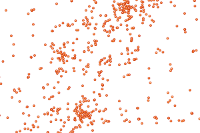

In [17]:
schoolpoints = gis.content.get("2885484aea3b4ae09074ed04bbc1c58f")
schoolpoints

In [18]:
sdf = pandas.DataFrame.spatial.from_layer(schoolpoints.layers[0])

##. We really should just get rid of these columns instead of dropping them every time through
sdf = sdf.drop(['OPSTFIPS', 'STATE', 'ZIP', 'NECTA', 'NMNECTA', 'CD', 'SLDL', 'SLDU', 'SCHOOLYEAR'], 1)
sdf = sdf.drop(['STFIP', 'LOCALE', 'CBSA', 'NMCBSA', 'CBSATYPE', 'CSA', 'NMCSA', 'CNTY', 'FID_1'], 1)
sdf['facilityid'] = pandas.to_numeric(sdf['School_ID'])

schools1_df = results2_df[results2_df['facilityid'] < 3776] 
schools1_df['school_total_num'] = schools1_df.school_total.str.replace('<6', '1')
schools1_df['dateupdated'] = schools1_df.dateupdated.str.strip('T00:00:00.000')
schools1_df['school_total_num'] = pandas.to_numeric(schools1_df['school_total_num'])

sdf_cases = sdf.set_index('facilityid').join(schools1_df.set_index('facilityid'))#, on='facilityid', rsuffix='1')

## TRYING TO SORT OUT WHY WE LOST SCHOOLS IN THE JOIN <-- this is working now, but it's a good check anyway
sdf_cases[sdf_cases['CITY']=='Prospect']

FID       NCESSCH    LEAID                        NAME  \
facilityid                                                           
3570        522  090353801811  0903538  Prospect Elementary School   
3571        520  090353800756  0903538    Long River Middle School   

                       STREET      CITY            NMCNTY        LAT  \
facilityid                                                             
3570        75 New Haven Road  Prospect  New Haven County  41.491750   
3571         38 Columbia Ave.  Prospect  New Haven County  41.504061   

                  LON                     District  School_ID  \
facilityid                                                      
3570       -72.971841  Regional School District 16       3570   
3571       -72.976113  Regional School District 16       3571   

                            School_nam  \
facilityid                               
3570        Prospect Elementary School   
3571          Long River Middle School   

                                                        SHAPE  \
facilityid                                                      
3570        {'x': -8123188.31178617, 'y': 5085148.76046250...   
3571        {'x': -8123663.868957047, 'y': 5086978.5219638...   

                               district                facilityname      city  \
facilityid                                                                      
3570        Regional School District 16  Prospect Elementary School  Prospect   
3571        Regional School District 16    Long River Middle School  Prospect   

           school_total       reporting_period dateupdated  school_total_num  
facilityid                                                                    
3570                  0  12/17/2020-12/23/2020  2020-12-23               0.0  
3571                  0  12/17/2020-12/23/2020  2020-12-23               0.0

***
<br>
<br>
$\large{\color{red}{\text{Update online layer using ESRI method}}}$ 
$\large{\color{red}{\text{from https://developers.arcgis.com/python/sample-notebooks/updating-features-in-a-feature-layer/}}}$

In [20]:
#Method 1 overwrite line by line

# from API docs, sdf_cases is the equivalent of cities_df_2 and old_school is the equivalent of cities_item

old_school = gis.content.get('8593429eed2f4898acbd26668b94af45')
old_school_layer = old_school.layers[0]

In [21]:
#Method 1 overwrite line by line
old_school_fset = old_school_layer.query() #querying without any conditions returns all the features
old_school_fset.sdf[0:4]

FID  FID_1       NCESSCH    LEAID                                  NAME  \
0    1    660  090002801366  0900028     New Beginnings Inc Family Academy   
1    2    662  090003101405  0900031                      Stamford Academy   
2    3    663  090003301449  0900033         Park City Prep Charter School   
3    4    678  090020801493  0900208  Achievement First Bridgeport Academy   

              STREET        CITY            NMCNTY        LAT        LON  ...  \
0     184 Garden St.  Bridgeport  Fairfield County  41.169724 -73.198901  ...   
1      229 North St.    Stamford  Fairfield County  41.059308 -73.536454  ...   
2  1550 State Street  Bridgeport  Fairfield County  41.169610 -73.212400  ...   
3   655 Stillman St.  Bridgeport  Fairfield County  41.186149 -73.185247  ...   

                             School_nam  \
0     New Beginnings Inc Family Academy   
1                      Stamford Academy   
2         Park City Prep Charter School   
3  Achievement First Bridgeport Academy   

                                      district_1  \
0     New Beginnings Inc Family Academy District   
1                      Stamford Academy District   
2         Park City Prep Charter School District   
3  Achievement First Bridgeport Academy District   

                             facilityna      city_1 school_tot  \
0     New Beginnings Inc Family Academy  Bridgeport          0   
1                      Stamford Academy    Stamford          0   
2         Park City Prep Charter School  Bridgeport         <6   
3  Achievement First Bridgeport Academy  Bridgeport          0   

              reporting_  dateupdate school_t_1  \
0  11/19/2020-11/25/2020  2020-11-25        0.0   
1  11/19/2020-11/25/2020  2020-11-25        0.0   
2  11/19/2020-11/25/2020  2020-11-25        1.0   
3  11/19/2020-11/25/2020  2020-11-25        0.0   

                               GlobalID  \
0  b7e297af-70ab-41f0-bd4c-b960bdc80bd3   
1  7bb690a2-676c-486c-8bb4-59681589e21a   
2  f3ef84c6-403b-48b8-b1bd-c918d8fc2953   
3  a35ff3a1-a9c6-43b3-b7f5-2fa1cafbfa32   

                                               SHAPE  
0  {'x': -8148464.521385655, 'y': 5037409.4776545...  
1  {'x': -8186040.760870938, 'y': 5021094.7514522...  
2  {'x': -8149967.223712323, 'y': 5037392.6190955...  
3  {'x': -8146944.56464322, 'y': 5039838.73224152...  

[4 rows x 22 columns]

In [22]:
#Method 1 overwrite line by line

overlap_rows = pandas.merge(left = old_school_fset.sdf, right = sdf_cases, how='inner',on = 'NAME')
overlap_rows = overlap_rows.dropna()

len(overlap_rows)

1034

In [23]:
#Method 1 overwrite line by line

features_for_update = [] #list containing corrected features
all_features = old_school_fset.features

# inspect one of the features
all_features[0]


{"geometry": {"x": -8148464.521385655, "y": 5037409.477654533, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 1, "FID_1": 660, "NCESSCH": "090002801366", "LEAID": "0900028", "NAME": "New Beginnings Inc Family Academy", "STREET": "184 Garden St.", "CITY": "Bridgeport", "NMCNTY": "Fairfield County", "LAT": 41.169724, "LON": -73.198901, "District": "New Beginnings Inc Family Academy District", "School_ID": 3670, "School_nam": "New Beginnings Inc Family Academy", "district_1": "New Beginnings Inc Family Academy District", "facilityna": "New Beginnings Inc Family Academy", "city_1": "Bridgeport", "school_tot": "0", "reporting_": "11/19/2020-11/25/2020", "dateupdate": "2020-11-25", "school_t_1": 0, "GlobalID": "b7e297af-70ab-41f0-bd4c-b960bdc80bd3", "SHAPE": {"x": -8148464.521385655, "y": 5037409.477654533, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}

In [24]:

for school in overlap_rows['NAME']:
    # get the feature to be updated
    original_feature = [f for f in all_features if f.attributes['NAME'] == school][0]
    feature_to_be_updated = deepcopy(original_feature)
    
    print(str(original_feature))
    
    # get the matching row from csv
    matching_row = sdf_cases.where(sdf_cases.NAME == school).dropna()
    
    #get geometries in the destination coordinate system
    #input_geometry = {'y':float(matching_row['latitude']),
    #                  'x':float(matching_row['longitude'])}
    #output_geometry = geometry.project(geometries = [input_geometry],
    #                                   in_sr = 4326, 
    #                                 gis = gis)
    
    # assign the updated values
    #feature_to_be_updated.geometry = output_geometry[0]
    feature_to_be_updated.attributes['school_tot'] = matching_row['school_total'].iloc[0]
    feature_to_be_updated.attributes['reporting_'] = matching_row['reporting_period'].iloc[0]
    feature_to_be_updated.attributes['dateupdate'] = matching_row['dateupdated'].iloc[0]
    feature_to_be_updated.attributes['school_t_1'] = int(matching_row['school_total_num'].iloc[0])
    
    #add this to the list of features to be updated
    features_for_update.append(feature_to_be_updated)
    
    print(str(feature_to_be_updated))
    print("========================================================================")

{"geometry": {"x": -8148464.521385655, "y": 5037409.477654533, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 1, "FID_1": 660, "NCESSCH": "090002801366", "LEAID": "0900028", "NAME": "New Beginnings Inc Family Academy", "STREET": "184 Garden St.", "CITY": "Bridgeport", "NMCNTY": "Fairfield County", "LAT": 41.169724, "LON": -73.198901, "District": "New Beginnings Inc Family Academy District", "School_ID": 3670, "School_nam": "New Beginnings Inc Family Academy", "district_1": "New Beginnings Inc Family Academy District", "facilityna": "New Beginnings Inc Family Academy", "city_1": "Bridgeport", "school_tot": "0", "reporting_": "11/19/2020-11/25/2020", "dateupdate": "2020-11-25", "school_t_1": 0, "GlobalID": "b7e297af-70ab-41f0-bd4c-b960bdc80bd3", "SHAPE": {"x": -8148464.521385655, "y": 5037409.477654533, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8148464.521385655, "y": 5037409.477654533, "spatialReference": {"wkid": 1

{"geometry": {"x": -8107499.383137765, "y": 5090690.3910684865, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 21, "FID_1": 16, "NCESSCH": "090000201142", "LEAID": "0900002", "NAME": "H. C. Wilcox Technical High School", "STREET": "298 Oregon Rd.", "CITY": "Meriden", "NMCNTY": "New Haven County", "LAT": 41.529028, "LON": -72.830905, "District": "Connecticut Technical Education and Career System", "School_ID": 3690, "School_nam": "H. C. Wilcox Technical High School", "district_1": "Connecticut Technical Education and Career System", "facilityna": "H. C. Wilcox Technical High School", "city_1": "Meriden", "school_tot": "0", "reporting_": "12/17/2020-12/23/2020", "dateupdate": "2020-12-23", "school_t_1": 0, "GlobalID": "e7b27cae-76db-4ffd-a1ea-d917582fe0f9", "SHAPE": {"x": -8107499.383137765, "y": 5090690.3910684865, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8090114.167350744, "y": 5090623.477259793, "spatialReference

{"geometry": {"x": -8109960.214358754, "y": 5126964.94081645, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 100, "FID_1": 674, "NCESSCH": "090012001367", "LEAID": "0900120", "NAME": "Thompson Brook School", "STREET": "150 Thompson Rd.", "CITY": "Avon", "NMCNTY": "Hartford County", "LAT": 41.772513, "LON": -72.853011, "District": "Avon School District", "School_ID": 1424, "School_nam": "Thompson Brook School", "district_1": "Avon School District", "facilityna": "Thompson Brook School", "city_1": "Avon", "school_tot": "0", "reporting_": "12/17/2020-12/23/2020", "dateupdate": "2020-12-23", "school_t_1": 0, "GlobalID": "007a28e7-22af-400e-bd1a-8a42d2e0323a", "SHAPE": {"x": -8109960.214358754, "y": 5126964.94081645, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8111360.502836438, "y": 5129866.451574991, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 101, "FID_1": 672, "NCESSCH": "090012000

{"geometry": {"x": -8091660.508629814, "y": 5127340.942002565, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 122, "FID_1": 704, "NCESSCH": "090033001619", "LEAID": "0900330", "NAME": "Learning Academy at Bloomfield", "STREET": "20-28 Sargeant Street", "CITY": "Hartford", "NMCNTY": "Hartford County", "LAT": 41.775032, "LON": -72.688622, "District": "Bloomfield School District", "School_ID": 1470, "School_nam": "Learning Academy at Bloomfield", "district_1": "Bloomfield School District", "facilityna": "Learning Academy at Bloomfield", "city_1": "Hartford", "school_tot": "0", "reporting_": "12/17/2020-12/23/2020", "dateupdate": "2020-12-23", "school_t_1": 0, "GlobalID": "5dad9f98-0142-46bf-a877-95b5cf634069", "SHAPE": {"x": -8091660.508629814, "y": 5127340.942002565, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8064084.546731981, "y": 5127421.847106777, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attribu

{"geometry": {"x": -8144144.321962068, "y": 5038690.066463198, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 144, "FID_1": 732, "NCESSCH": "090045000076", "LEAID": "0900450", "NAME": "Jettie S. Tisdale School", "STREET": "250 Hollister Avenue", "CITY": "Bridgeport", "NMCNTY": "Fairfield County", "LAT": 41.178383, "LON": -73.160092, "District": "Bridgeport School District", "School_ID": 1525, "School_nam": "Jettie S. Tisdale School", "district_1": "Bridgeport School District", "facilityna": "Jettie S. Tisdale School", "city_1": "Bridgeport", "school_tot": "0", "reporting_": "12/17/2020-12/23/2020", "dateupdate": "2020-12-23", "school_t_1": 0, "GlobalID": "3c57f1f0-0f47-4966-bec1-bb7c2ee4a3ab", "SHAPE": {"x": -8144144.321962068, "y": 5038690.066463198, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8148396.616668514, "y": 5042268.4478945015, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID":

{"geometry": {"x": -8117137.762892294, "y": 5114435.364020594, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 165, "FID_1": 756, "NCESSCH": "090051000106", "LEAID": "0900510", "NAME": "Stafford School", "STREET": "212 Louisiana Ave.", "CITY": "Bristol", "NMCNTY": "Hartford County", "LAT": 41.688515, "LON": -72.917488, "District": "Bristol School District", "School_ID": 1595, "School_nam": "Stafford School", "district_1": "Bristol School District", "facilityna": "Stafford School", "city_1": "Bristol", "school_tot": "<6", "reporting_": "12/17/2020-12/23/2020", "dateupdate": "2020-12-23", "school_t_1": 1, "GlobalID": "5fe31884-d8e1-4e31-87fc-9df5402c50c4", "SHAPE": {"x": -8117137.762892294, "y": 5114435.364020594, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8116092.02722502, "y": 5113000.24757306, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 166, "FID_1": 750, "NCESSCH": "090051000097

{"geometry": {"x": -8114799.940375567, "y": 5089368.541515957, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 188, "FID_1": 786, "NCESSCH": "090075000122", "LEAID": "0900750", "NAME": "Chapman School", "STREET": "38 Country Club Rd.", "CITY": "Cheshire", "NMCNTY": "New Haven County", "LAT": 41.520138, "LON": -72.896487, "District": "Cheshire School District", "School_ID": 1646, "School_nam": "Chapman School", "district_1": "Cheshire School District", "facilityna": "Chapman School", "city_1": "Cheshire", "school_tot": "<6", "reporting_": "11/19/2020-11/25/2020", "dateupdate": "2020-11-25", "school_t_1": 1, "GlobalID": "675e440c-bce9-4a51-b0b5-e711c9cdfe7b", "SHAPE": {"x": -8114799.940375567, "y": 5089368.541515957, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8114799.940375567, "y": 5089368.541515957, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 188, "FID_1": 786, "NCESSCH": "0900750

{"geometry": {"x": -8049808.04014441, "y": 5128419.918220672, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 208, "FID_1": 807, "NCESSCH": "090096000143", "LEAID": "0900960", "NAME": "Coventry High School", "STREET": "78 Ripley Hill Road", "CITY": "Coventry", "NMCNTY": "Tolland County", "LAT": 41.78226, "LON": -72.312655, "District": "Coventry School District", "School_ID": 1688, "School_nam": "Coventry High School", "district_1": "Coventry School District", "facilityna": "Coventry High School", "city_1": "Coventry", "school_tot": "<6", "reporting_": "12/17/2020-12/23/2020", "dateupdate": "2020-12-23", "school_t_1": 1, "GlobalID": "0abf773d-6eab-428f-9a31-ac128b25829d", "SHAPE": {"x": -8049808.04014441, "y": 5128419.918220672, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8088307.006893034, "y": 5104170.688726619, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 209, "FID_1": 810, "NCESS

{"geometry": {"x": -8175457.615782159, "y": 5071746.410126478, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 230, "FID_1": 827, "NCESSCH": "090102001129", "LEAID": "0901020", "NAME": "Alternative Center For Excellence", "STREET": "26 Locust Avenue", "CITY": "Danbury", "NMCNTY": "Fairfield County", "LAT": 41.401505, "LON": -73.441384, "District": "Danbury School District", "School_ID": 1733, "School_nam": "Alternative Center For Excellence", "district_1": "Danbury School District", "facilityna": "Alternative Center For Excellence", "city_1": "Danbury", "school_tot": "<6", "reporting_": "12/17/2020-12/23/2020", "dateupdate": "2020-12-23", "school_t_1": 1, "GlobalID": "6ee77677-e499-46cd-a2e2-7ee9e4c45c7b", "SHAPE": {"x": -8175457.615782159, "y": 5071746.410126478, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8180679.167140094, "y": 5021071.573270217, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attribute

{"geometry": {"x": -8073197.941082328, "y": 5096516.871569811, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 252, "FID_1": 853, "NCESSCH": "090123000188", "LEAID": "0901230", "NAME": "East Hampton Middle School", "STREET": "19 Childs Rd.", "CITY": "East Hampton", "NMCNTY": "Middlesex County", "LAT": 41.568199, "LON": -72.52277, "District": "East Hampton School District", "School_ID": 1768, "School_nam": "East Hampton Middle School", "district_1": "East Hampton School District", "facilityna": "East Hampton Middle School", "city_1": "East Hampton", "school_tot": "0", "reporting_": "12/17/2020-12/23/2020", "dateupdate": "2020-12-23", "school_t_1": 0, "GlobalID": "4d9f9942-9068-4fe7-904d-b65296ee4de0", "SHAPE": {"x": -8073197.941082328, "y": 5096516.871569811, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8072154.320482804, "y": 5098640.782748024, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"

{"geometry": {"x": -8038982.992553595, "y": 5066690.014371789, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 274, "FID_1": 877, "NCESSCH": "090132000225", "LEAID": "0901320", "NAME": "Flanders School", "STREET": "167 Boston Post Rd.", "CITY": "East Lyme", "NMCNTY": "New London County", "LAT": 41.367425, "LON": -72.215412, "District": "East Lyme School District", "School_ID": 1806, "School_nam": "Flanders School", "district_1": "East Lyme School District", "facilityna": "Flanders School", "city_1": "East Lyme", "school_tot": "<6", "reporting_": "12/17/2020-12/23/2020", "dateupdate": "2020-12-23", "school_t_1": 1, "GlobalID": "c14204e2-29fc-4360-82e2-ce3aeecba388", "SHAPE": {"x": -8038982.992553595, "y": 5066690.014371789, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8037642.593920665, "y": 5060060.172517741, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 275, "FID_1": 879, "NCESSCH": 

{"geometry": {"x": -8160052.327560038, "y": 5039352.683817057, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 297, "FID_1": 905, "NCESSCH": "090153000257", "LEAID": "0901530", "NAME": "Dwight Elementary School", "STREET": "1600 Redding Rd.", "CITY": "Fairfield", "NMCNTY": "Fairfield County", "LAT": 41.182863, "LON": -73.302996, "District": "Fairfield School District", "School_ID": 1870, "School_nam": "Dwight Elementary School", "district_1": "Fairfield School District", "facilityna": "Dwight Elementary School", "city_1": "Fairfield", "school_tot": "0", "reporting_": "12/17/2020-12/23/2020", "dateupdate": "2020-12-23", "school_t_1": 0, "GlobalID": "734f9dcb-1b3d-4e98-9372-3b0439241d43", "SHAPE": {"x": -8160052.327560038, "y": 5039352.683817057, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8158254.40604503, "y": 5041602.374751097, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 298, "FID

{"geometry": {"x": -8028968.578340644, "y": 5105911.289891515, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 319, "FID_1": 927, "NCESSCH": "090159000278", "LEAID": "0901590", "NAME": "Franklin Elementary School", "STREET": "206 Pond Rd.", "CITY": "North Franklin", "NMCNTY": "New London County", "LAT": 41.631307, "LON": -72.125451, "District": "Franklin School District", "School_ID": 1914, "School_nam": "Franklin Elementary School", "district_1": "Franklin School District", "facilityna": "Franklin Elementary School", "city_1": "North Franklin", "school_tot": "<6", "reporting_": "12/17/2020-12/23/2020", "dateupdate": "2020-12-23", "school_t_1": 1, "GlobalID": "db394135-57a2-4c44-a838-778334dc4149", "SHAPE": {"x": -8028968.578340644, "y": 5105911.289891515, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8081486.905109575, "y": 5114577.726595369, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FI

{"geometry": {"x": -8199062.696807231, "y": 5028861.863297502, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 340, "FID_1": 940, "NCESSCH": "090171000107", "LEAID": "0901710", "NAME": "Parkway School", "STREET": "141 Lower Cross Rd.", "CITY": "Greenwich", "NMCNTY": "Fairfield County", "LAT": 41.111898, "LON": -73.653432, "District": "Greenwich School District", "School_ID": 1949, "School_nam": "Parkway School", "district_1": "Greenwich School District", "facilityna": "Parkway School", "city_1": "Greenwich", "school_tot": "<6", "reporting_": "12/17/2020-12/23/2020", "dateupdate": "2020-12-23", "school_t_1": 1, "GlobalID": "a800b8ea-8cbd-4b58-ba0d-a703e5467761", "SHAPE": {"x": -8199062.696807231, "y": 5028861.863297502, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8190515.137791251, "y": 5019949.041039218, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 341, "FID_1": 954, "NCESSCH": "090

{"geometry": {"x": -8095077.792568705, "y": 5062246.92753976, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 362, "FID_1": 968, "NCESSCH": "090180000328", "LEAID": "0901800", "NAME": "A. Baldwin Middle School", "STREET": "68 Bullard Dr.", "CITY": "Guilford", "NMCNTY": "New Haven County", "LAT": 41.337464, "LON": -72.71932, "District": "Guilford School District", "School_ID": 2000, "School_nam": "A. Baldwin Middle School", "district_1": "Guilford School District", "facilityna": "A. Baldwin Middle School", "city_1": "Guilford", "school_tot": "<6", "reporting_": "12/17/2020-12/23/2020", "dateupdate": "2020-12-23", "school_t_1": 1, "GlobalID": "99c7041e-26fb-4555-986d-ab10b463526a", "SHAPE": {"x": -8095077.792568705, "y": 5062246.92753976, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8091247.732640433, "y": 5055516.867010062, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 363, "FID_1": 97

{"geometry": {"x": -8093179.908949348, "y": 5129821.809485618, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 383, "FID_1": 1014, "NCESSCH": "090192001643", "LEAID": "0901920", "NAME": "Hartford PreKindergarten Magnet School", "STREET": "121 Cornwall Street", "CITY": "Hartford", "NMCNTY": "Hartford County", "LAT": 41.79165, "LON": -72.702271, "District": "Hartford School District", "School_ID": 2070, "School_nam": "Hartford PreKindergarten Magnet School", "district_1": "Hartford School District", "facilityna": "Hartford PreKindergarten Magnet School", "city_1": "Hartford", "school_tot": "0", "reporting_": "12/17/2020-12/23/2020", "dateupdate": "2020-12-23", "school_t_1": 0, "GlobalID": "23572b5d-2f4e-4b7b-9b7d-4c2295df921a", "SHAPE": {"x": -8093179.908949348, "y": 5129821.809485618, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8090129.976148178, "y": 5120706.458902847, "spatialReference": {"wkid": 102100, "latestWkid"

{"geometry": {"x": -8077415.950607623, "y": 5125298.717724526, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 404, "FID_1": 1005, "NCESSCH": "090192001403", "LEAID": "0901920", "NAME": "Great Path Academy at MCC", "STREET": "60 Bidwell Street", "CITY": "Manchester", "NMCNTY": "Hartford County", "LAT": 41.761349, "LON": -72.560661, "District": "Hartford School District", "School_ID": 2161, "School_nam": "Great Path Academy at MCC", "district_1": "Hartford School District", "facilityna": "Great Path Academy at MCC", "city_1": "Manchester", "school_tot": "<6", "reporting_": "12/17/2020-12/23/2020", "dateupdate": "2020-12-23", "school_t_1": 1, "GlobalID": "a480afed-619c-4849-bbc3-1272c73c40c0", "SHAPE": {"x": -8077415.950607623, "y": 5125298.717724526, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8115958.33466052, "y": 5160530.450137622, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 405,

{"geometry": {"x": -8084666.522488436, "y": 5062682.678142429, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 426, "FID_1": 15, "NCESSCH": "090228000413", "LEAID": "0902280", "NAME": "Kathleen H. Ryerson Elementary School", "STREET": "982 Durham Rd.", "CITY": "Madison", "NMCNTY": "New Haven County", "LAT": 41.340403, "LON": -72.625794, "District": "Madison School District", "School_ID": 2219, "School_nam": "Kathleen H. Ryerson Elementary School", "district_1": "Madison School District", "facilityna": "Kathleen H. Ryerson Elementary School", "city_1": "Madison", "school_tot": "<6", "reporting_": "12/17/2020-12/23/2020", "dateupdate": "2020-12-23", "school_t_1": 1, "GlobalID": "69f4ebaf-490c-4e1a-b138-1f4e7e43e6fc", "SHAPE": {"x": -8084666.522488436, "y": 5062682.678142429, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8083875.708297518, "y": 5056022.989117341, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "

{"geometry": {"x": -8102253.45058587, "y": 5091753.057780498, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 447, "FID_1": 273, "NCESSCH": "090240000450", "LEAID": "0902400", "NAME": "Roger Sherman School", "STREET": "64 North Pearl St.", "CITY": "Meriden", "NMCNTY": "New Haven County", "LAT": 41.536174, "LON": -72.78378, "District": "Meriden School District", "School_ID": 2287, "School_nam": "Roger Sherman School", "district_1": "Meriden School District", "facilityna": "Roger Sherman School", "city_1": "Meriden", "school_tot": "<6", "reporting_": "12/17/2020-12/23/2020", "dateupdate": "2020-12-23", "school_t_1": 1, "GlobalID": "6f2d8057-e9e5-42eb-826f-41b869a82845", "SHAPE": {"x": -8102253.45058587, "y": 5091753.057780498, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8101714.329957752, "y": 5088962.359166629, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 448, "FID_1": 274, "NCESSCH"

{"geometry": {"x": -8134566.501401598, "y": 5043578.3868416855, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 467, "FID_1": 295, "NCESSCH": "090252000478", "LEAID": "0902520", "NAME": "Meadowside School", "STREET": "80 Seeman's Ln.", "CITY": "Milford", "NMCNTY": "New Haven County", "LAT": 41.211426, "LON": -73.074053, "District": "Milford School District", "School_ID": 2374, "School_nam": "Meadowside School", "district_1": "Milford School District", "facilityna": "Meadowside School", "city_1": "Milford", "school_tot": "<6", "reporting_": "12/17/2020-12/23/2020", "dateupdate": "2020-12-23", "school_t_1": 1, "GlobalID": "e6dc3667-b5f8-456a-b869-d12fef77e9bc", "SHAPE": {"x": -8134566.501401598, "y": 5043578.3868416855, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8131924.221354505, "y": 5047601.936912007, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 468, "FID_1": 296, "NCESSCH": "0902

{"geometry": {"x": -8132478.371607802, "y": 5086595.626651262, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 490, "FID_1": 313, "NCESSCH": "090264000504", "LEAID": "0902640", "NAME": "Hillside Intermediate School", "STREET": "51 Hillside Ave.", "CITY": "Naugatuck", "NMCNTY": "New Haven County", "LAT": 41.501485, "LON": -73.055295, "District": "Naugatuck School District", "School_ID": 2414, "School_nam": "Hillside Intermediate School", "district_1": "Naugatuck School District", "facilityna": "Hillside Intermediate School", "city_1": "Naugatuck", "school_tot": "<6", "reporting_": "12/17/2020-12/23/2020", "dateupdate": "2020-12-23", "school_t_1": 1, "GlobalID": "1208dad3-f952-4856-8d0e-443251a1912e", "SHAPE": {"x": -8132478.371607802, "y": 5086595.626651262, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8131137.973175087, "y": 5086621.638047249, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"F

{"geometry": {"x": -8099757.444988298, "y": 5110981.7896849625, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 510, "FID_1": 332, "NCESSCH": "090267001445", "LEAID": "0902670", "NAME": "House of Arts Letters and Science (HALS)  Academy", "STREET": "30 Pendleton Rd.", "CITY": "New Britain", "NMCNTY": "Hartford County", "LAT": 41.665343, "LON": -72.761358, "District": "New Britain School District", "School_ID": 2464, "School_nam": "House of Arts Letters and Science (HALS)  Academy", "district_1": "New Britain School District", "facilityna": "House of Arts Letters and Science (HALS)  Academy", "city_1": "New Britain", "school_tot": "0", "reporting_": "12/17/2020-12/23/2020", "dateupdate": "2020-12-23", "school_t_1": 0, "GlobalID": "63c19610-f471-42d4-b3e2-83e9014898ab", "SHAPE": {"x": -8099757.444988298, "y": 5110981.7896849625, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8101608.46604653, "y": 5108786.7654784685, "spat

{"geometry": {"x": -8121947.209312077, "y": 5059372.860285529, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 531, "FID_1": 354, "NCESSCH": "090279000553", "LEAID": "0902790", "NAME": "Edgewood School", "STREET": "737 Edgewood Ave.", "CITY": "New Haven", "NMCNTY": "New Haven County", "LAT": 41.318076, "LON": -72.960692, "District": "New Haven School District", "School_ID": 2524, "School_nam": "Edgewood School", "district_1": "New Haven School District", "facilityna": "Edgewood School", "city_1": "New Haven", "school_tot": "0", "reporting_": "12/17/2020-12/23/2020", "dateupdate": "2020-12-23", "school_t_1": 0, "GlobalID": "fe05ce35-88ee-409a-96e7-2293f05eeb55", "SHAPE": {"x": -8121947.209312077, "y": 5059372.860285529, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8121947.209312077, "y": 5059372.860285529, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 531, "FID_1": 354, "NCESSCH": "090

{"geometry": {"x": -8117275.9078411, "y": 5056873.053336797, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 553, "FID_1": 376, "NCESSCH": "090279001485", "LEAID": "0902790", "NAME": "Metropolitan Business Academy", "STREET": "115 Water Street", "CITY": "New Haven", "NMCNTY": "New Haven County", "LAT": 41.301208, "LON": -72.918729, "District": "New Haven School District", "School_ID": 2589, "School_nam": "Metropolitan Business Academy", "district_1": "New Haven School District", "facilityna": "Metropolitan Business Academy", "city_1": "New Haven", "school_tot": "0", "reporting_": "12/17/2020-12/23/2020", "dateupdate": "2020-12-23", "school_t_1": 0, "GlobalID": "917c422f-42c9-492a-89b3-7b267567a6cd", "SHAPE": {"x": -8117275.9078411, "y": 5056873.053336797, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8116037.589583846, "y": 5060318.385526963, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID

{"geometry": {"x": -8170022.441380129, "y": 5104262.41289084, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 576, "FID_1": 388, "NCESSCH": "090285000603", "LEAID": "0902850", "NAME": "Schaghticoke Middle School", "STREET": "23 Hipp Rd.", "CITY": "New Milford", "NMCNTY": "Litchfield County", "LAT": 41.620235, "LON": -73.392559, "District": "New Milford School District", "School_ID": 2659, "School_nam": "Schaghticoke Middle School", "district_1": "New Milford School District", "facilityna": "Schaghticoke Middle School", "city_1": "New Milford", "school_tot": "<6", "reporting_": "12/17/2020-12/23/2020", "dateupdate": "2020-12-23", "school_t_1": 1, "GlobalID": "e9776754-73fe-4d42-b85a-3856f6c07ea2", "SHAPE": {"x": -8170022.441380129, "y": 5104262.41289084, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8173571.307220709, "y": 5090380.05686701, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 

{"geometry": {"x": -8171023.534571593, "y": 5032602.457439575, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 599, "FID_1": 435, "NCESSCH": "090309001914", "LEAID": "0903090", "NAME": "Norwalk Early Childhood Center", "STREET": "11 Allen Road", "CITY": "Norwalk", "NMCNTY": "Fairfield County", "LAT": 41.13721, "LON": -73.401552, "District": "Norwalk School District", "School_ID": 2701, "School_nam": "Norwalk Early Childhood Center", "district_1": "Norwalk School District", "facilityna": "Norwalk Early Childhood Center", "city_1": "Norwalk", "school_tot": "<6", "reporting_": "12/17/2020-12/23/2020", "dateupdate": "2020-12-23", "school_t_1": 1, "GlobalID": "732c7405-cef0-49df-9664-851f7334689c", "SHAPE": {"x": -8171023.534571593, "y": 5032602.457439575, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8174796.264320582, "y": 5025669.196398206, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 6

{"geometry": {"x": -8027479.456216571, "y": 5087884.246466475, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 621, "FID_1": 443, "NCESSCH": "090312000675", "LEAID": "0903120", "NAME": "Thomas W. Mahan School", "STREET": "94 Salem Tpke.", "CITY": "Norwich", "NMCNTY": "New London County", "LAT": 41.510154, "LON": -72.112074, "District": "Norwich School District", "School_ID": 2771, "School_nam": "Thomas W. Mahan School", "district_1": "Norwich School District", "facilityna": "Thomas W. Mahan School", "city_1": "Norwich", "school_tot": "0", "reporting_": "12/17/2020-12/23/2020", "dateupdate": "2020-12-23", "school_t_1": 0, "GlobalID": "a6bbb318-7019-4264-9288-9e86bc8cf01f", "SHAPE": {"x": -8027479.456216571, "y": 5087884.246466475, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8023045.599457275, "y": 5086944.041575333, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 622, "FID_1": 444, "NCE

{"geometry": {"x": -8110561.339098468, "y": 5111597.087908877, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 642, "FID_1": 464, "NCESSCH": "090330000701", "LEAID": "0903300", "NAME": "Linden Street School", "STREET": "69 Linden St.", "CITY": "Plainville", "NMCNTY": "Hartford County", "LAT": 41.669472, "LON": -72.858411, "District": "Plainville School District", "School_ID": 2809, "School_nam": "Linden Street School", "district_1": "Plainville School District", "facilityna": "Linden Street School", "city_1": "Plainville", "school_tot": "0", "reporting_": "12/17/2020-12/23/2020", "dateupdate": "2020-12-23", "school_t_1": 0, "GlobalID": "49f7e19a-149c-458d-a85b-5f6489d3c6fe", "SHAPE": {"x": -8110561.339098468, "y": 5111597.087908877, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8109827.2982634865, "y": 5113926.907884715, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 643, "FID_1": 463, 

{"geometry": {"x": -8181571.839958456, "y": 5053678.9864819795, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 665, "FID_1": 550, "NCESSCH": "090381000781", "LEAID": "0903810", "NAME": "Veterans Park Elementary School", "STREET": "8 Governor St.", "CITY": "Ridgefield", "NMCNTY": "Fairfield County", "LAT": 41.279649, "LON": -73.496309, "District": "Ridgefield School District", "School_ID": 2853, "School_nam": "Veterans Park Elementary School", "district_1": "Ridgefield School District", "facilityna": "Veterans Park Elementary School", "city_1": "Ridgefield", "school_tot": "<6", "reporting_": "12/17/2020-12/23/2020", "dateupdate": "2020-12-23", "school_t_1": 1, "GlobalID": "473b6715-6e89-4dfb-9fb8-781399f29f54", "SHAPE": {"x": -8181571.839958456, "y": 5053678.9864819795, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8183398.482425641, "y": 5062479.696627161, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "att

{"geometry": {"x": -8141410.649203794, "y": 5059013.5871576285, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 686, "FID_1": 567, "NCESSCH": "090405000798", "LEAID": "0904050", "NAME": "Elizabeth Shelton School", "STREET": "138 Willoughby Rd.", "CITY": "Shelton", "NMCNTY": "Fairfield County", "LAT": 41.315652, "LON": -73.135535, "District": "Shelton School District", "School_ID": 2901, "School_nam": "Elizabeth Shelton School", "district_1": "Shelton School District", "facilityna": "Elizabeth Shelton School", "city_1": "Shelton", "school_tot": "0", "reporting_": "12/17/2020-12/23/2020", "dateupdate": "2020-12-23", "school_t_1": 0, "GlobalID": "44b4bbe8-48a0-45c7-9d67-7d5be6c79561", "SHAPE": {"x": -8141410.649203794, "y": 5059013.5871576285, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8134563.7188866595, "y": 5055418.63661993, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 687, "FID_1"

{"geometry": {"x": -8066322.181992315, "y": 5157963.7290986525, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 704, "FID_1": 582, "NCESSCH": "090414000818", "LEAID": "0904140", "NAME": "Mabelle B. Avery Middle School", "STREET": "1 Vision Boulevard", "CITY": "Somers", "NMCNTY": "Tolland County", "LAT": 41.979856, "LON": -72.461004, "District": "Somers School District", "School_ID": 2930, "School_nam": "Mabelle B. Avery Middle School", "district_1": "Somers School District", "facilityna": "Mabelle B. Avery Middle School", "city_1": "Somers", "school_tot": "0", "reporting_": "12/17/2020-12/23/2020", "dateupdate": "2020-12-23", "school_t_1": 0, "GlobalID": "7e5b4ea6-8382-4b60-a743-42ed8d96bbcf", "SHAPE": {"x": -8066322.181992315, "y": 5157963.7290986525, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8066067.705514125, "y": 5157502.51697935, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 7

{"geometry": {"x": -8024551.308149474, "y": 5104651.5286510475, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 724, "FID_1": 601, "NCESSCH": "090426000842", "LEAID": "0904260", "NAME": "Sayles School", "STREET": "25 Scotland Road", "CITY": "Baltic", "NMCNTY": "New London County", "LAT": 41.622848, "LON": -72.08577, "District": "Sprague School District", "School_ID": 2970, "School_nam": "Sayles School", "district_1": "Sprague School District", "facilityna": "Sayles School", "city_1": "Sprague", "school_tot": "0", "reporting_": "12/17/2020-12/23/2020", "dateupdate": "2020-12-23", "school_t_1": 0, "GlobalID": "3a203df4-0d09-4d26-b2ae-c0e99a22d8a6", "SHAPE": {"x": -8024551.308149474, "y": 5104651.5286510475, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8043801.90767328, "y": 5160093.980932723, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 725, "FID_1": 604, "NCESSCH": "090429000847", "LE

{"geometry": {"x": -8185592.588456412, "y": 5021505.179005323, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 748, "FID_1": 620, "NCESSCH": "090432000867", "LEAID": "0904320", "NAME": "Stamford High School", "STREET": "55 Strawberry Hill Ave.", "CITY": "Stamford", "NMCNTY": "Fairfield County", "LAT": 41.062088, "LON": -73.532428, "District": "Stamford School District", "School_ID": 3021, "School_nam": "Stamford High School", "district_1": "Stamford School District", "facilityna": "Stamford High School", "city_1": "Stamford", "school_tot": "<6", "reporting_": "12/17/2020-12/23/2020", "dateupdate": "2020-12-23", "school_t_1": 1, "GlobalID": "d0cb7844-bee1-4843-9491-636ae8540f4a", "SHAPE": {"x": -8185592.588456412, "y": 5021505.179005323, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8189215.482669359, "y": 5025899.761899118, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 749, "FID_1": 62

{"geometry": {"x": -8091464.921576426, "y": 5158751.284047853, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 769, "FID_1": 17, "NCESSCH": "090447000903", "LEAID": "0904470", "NAME": "A. Ward Spaulding School", "STREET": "945 Mountain Rd.", "CITY": "Suffield", "NMCNTY": "Hartford County", "LAT": 41.985115, "LON": -72.686865, "District": "Suffield School District", "School_ID": 3076, "School_nam": "A. Ward Spaulding School", "district_1": "Suffield School District", "facilityna": "A. Ward Spaulding School", "city_1": "Suffield", "school_tot": "0", "reporting_": "12/17/2020-12/23/2020", "dateupdate": "2020-12-23", "school_t_1": 0, "GlobalID": "68c4d940-5836-4fc5-85e5-ee905b7cc778", "SHAPE": {"x": -8091464.921576426, "y": 5158751.284047853, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8088879.8595831, "y": 5158722.68006571, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 770, "FID_1": 13,

{"geometry": {"x": -8145413.587764095, "y": 5050918.682077224, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 789, "FID_1": 40, "NCESSCH": "090462000927", "LEAID": "0904620", "NAME": "Booth Hill School", "STREET": "545 Booth Hill Rd.", "CITY": "Trumbull", "NMCNTY": "Fairfield County", "LAT": 41.261012, "LON": -73.171494, "District": "Trumbull School District", "School_ID": 3126, "School_nam": "Booth Hill School", "district_1": "Trumbull School District", "facilityna": "Booth Hill School", "city_1": "Trumbull", "school_tot": "0", "reporting_": "12/17/2020-12/23/2020", "dateupdate": "2020-12-23", "school_t_1": 0, "GlobalID": "86dcee93-e97e-41d4-8813-5c9f3fcabc36", "SHAPE": {"x": -8145413.587764095, "y": 5050918.682077224, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8145413.587764095, "y": 5050918.682077224, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 789, "FID_1": 40, "NCESSCH": "09

{"geometry": {"x": -8000127.580976509, "y": 5097454.742510256, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 807, "FID_1": 57, "NCESSCH": "090471000949", "LEAID": "0904710", "NAME": "Voluntown Elementary School", "STREET": "195 Main Street", "CITY": "Voluntown", "NMCNTY": "New London County", "LAT": 41.574502, "LON": -71.866368, "District": "Voluntown School District", "School_ID": 3162, "School_nam": "Voluntown Elementary School", "district_1": "Voluntown School District", "facilityna": "Voluntown Elementary School", "city_1": "Voluntown", "school_tot": "0", "reporting_": "12/17/2020-12/23/2020", "dateupdate": "2020-12-23", "school_t_1": 0, "GlobalID": "467989c9-c3be-4f83-85d9-12cf18075f83", "SHAPE": {"x": -8000127.580976509, "y": 5097454.742510256, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8105731.072070694, "y": 5080453.999003391, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 

{"geometry": {"x": -8131344.471443225, "y": 5097080.054753275, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 828, "FID_1": 79, "NCESSCH": "090483000975", "LEAID": "0904830", "NAME": "F. J. Kingsbury School", "STREET": "220 Columbia Blvd.", "CITY": "Waterbury", "NMCNTY": "New Haven County", "LAT": 41.571984, "LON": -73.045109, "District": "Waterbury School District", "School_ID": 3230, "School_nam": "F. J. Kingsbury School", "district_1": "Waterbury School District", "facilityna": "F. J. Kingsbury School", "city_1": "Waterbury", "school_tot": "0", "reporting_": "12/17/2020-12/23/2020", "dateupdate": "2020-12-23", "school_t_1": 0, "GlobalID": "d591aaa1-d11f-4535-a595-09681314d700", "SHAPE": {"x": -8131344.471443225, "y": 5097080.054753275, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8131571.45184044, "y": 5092831.159798731, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 829, "FID_1": 

{"geometry": {"x": -8132748.544357461, "y": 5093194.669367923, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 848, "FID_1": 83, "NCESSCH": "090483000979", "LEAID": "0904830", "NAME": "John F. Kennedy High School", "STREET": "422 Highland Ave.", "CITY": "Waterbury", "NMCNTY": "New Haven County", "LAT": 41.545867, "LON": -73.057722, "District": "Waterbury School District", "School_ID": 3289, "School_nam": "John F. Kennedy High School", "district_1": "Waterbury School District", "facilityna": "John F. Kennedy High School", "city_1": "Waterbury", "school_tot": "0", "reporting_": "12/17/2020-12/23/2020", "dateupdate": "2020-12-23", "school_t_1": 0, "GlobalID": "3e811666-296d-45e1-b4eb-71bb7e53f818", "SHAPE": {"x": -8132748.544357461, "y": 5093194.669367923, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8128580.296238444, "y": 5094918.2557874145, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID"

{"geometry": {"x": -8097602.410897304, "y": 5122693.247556783, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 869, "FID_1": 120, "NCESSCH": "090492001024", "LEAID": "0904920", "NAME": "Webster Hill School", "STREET": "125 Webster Hill Blvd.", "CITY": "West Hartford", "NMCNTY": "Hartford County", "LAT": 41.743888, "LON": -72.741999, "District": "West Hartford School District", "School_ID": 3353, "School_nam": "Webster Hill School", "district_1": "West Hartford School District", "facilityna": "Webster Hill School", "city_1": "West Hartford", "school_tot": "0", "reporting_": "12/17/2020-12/23/2020", "dateupdate": "2020-12-23", "school_t_1": 0, "GlobalID": "c962197f-99b0-435e-9272-ee27cc3cd287", "SHAPE": {"x": -8097602.410897304, "y": 5122693.247556783, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8095716.101534953, "y": 5125570.33159862, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 870

{"geometry": {"x": -8130075.206041639, "y": 5092828.036535412, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 883, "FID_1": 88, "NCESSCH": "090483000988", "LEAID": "0904830", "NAME": "Washington School", "STREET": "685 Baldwin St.", "CITY": "Waterbury", "NMCNTY": "New Haven County", "LAT": 41.543402, "LON": -73.033707, "District": "West Haven School District", "School_ID": 3389, "School_nam": "Washington School", "district_1": "West Haven School District", "facilityna": "Washington School", "city_1": "West Haven", "school_tot": "<6", "reporting_": "12/17/2020-12/23/2020", "dateupdate": "2020-12-23", "school_t_1": 1, "GlobalID": "cb9c263d-bfa5-4400-89f3-31a8174455eb", "SHAPE": {"x": -8130075.206041639, "y": 5092828.036535412, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8119677.40373812, "y": 5050950.374104968, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 886, "FID_1": 130, "NCESSCH"

{"geometry": {"x": -8089718.093859275, "y": 5117239.440920218, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 907, "FID_1": 154, "NCESSCH": "090507001068", "LEAID": "0905070", "NAME": "Wethersfield High School", "STREET": "411 Wolcott Hill Rd.", "CITY": "Wethersfield", "NMCNTY": "Hartford County", "LAT": 41.707323, "LON": -72.671173, "District": "Wethersfield School District", "School_ID": 3424, "School_nam": "Wethersfield High School", "district_1": "Wethersfield School District", "facilityna": "Wethersfield High School", "city_1": "Wethersfield", "school_tot": "<6", "reporting_": "12/17/2020-12/23/2020", "dateupdate": "2020-12-23", "school_t_1": 1, "GlobalID": "76a59c3b-6969-4818-81bc-252036a13c72", "SHAPE": {"x": -8089718.093859275, "y": 5117239.440920218, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8048644.417506486, "y": 5138763.823870291, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": 

{"geometry": {"x": -8088297.21212811, "y": 5137349.560728712, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 927, "FID_1": 174, "NCESSCH": "090522001095", "LEAID": "0905220", "NAME": "Sage Park Middle School", "STREET": "25 Sage Park Rd.", "CITY": "Windsor", "NMCNTY": "Hartford County", "LAT": 41.842048, "LON": -72.658409, "District": "Windsor School District", "School_ID": 3483, "School_nam": "Sage Park Middle School", "district_1": "Windsor School District", "facilityna": "Sage Park Middle School", "city_1": "Windsor", "school_tot": "<6", "reporting_": "12/17/2020-12/23/2020", "dateupdate": "2020-12-23", "school_t_1": 1, "GlobalID": "deb9a66b-fb5f-4b02-b805-e0da5e842ec2", "SHAPE": {"x": -8088297.21212811, "y": 5137349.560728712, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8088014.460697029, "y": 5137703.70407925, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 928, "FID_1": 175, "NC

{"geometry": {"x": -8127250.026444416, "y": 5065250.42939156, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 947, "FID_1": 537, "NCESSCH": "090366000770", "LEAID": "0903660", "NAME": "Amity Regional High School", "STREET": "25 Newton Rd.", "CITY": "Woodbridge", "NMCNTY": "New Haven County", "LAT": 41.357719, "LON": -73.008328, "District": "Regional School District 05", "School_ID": 3522, "School_nam": "Amity Regional High School", "district_1": "Regional School District 05", "facilityna": "Amity Regional High School", "city_1": "Woodbridge", "school_tot": "6", "reporting_": "12/17/2020-12/23/2020", "dateupdate": "2020-12-23", "school_t_1": 6, "GlobalID": "4da1045a-09e4-4b31-9664-80ea4e1a553d", "SHAPE": {"x": -8127250.026444416, "y": 5065250.42939156, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8151612.86485438, "y": 5136299.905768487, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 94

{"geometry": {"x": -8090591.282565801, "y": 5082845.371035711, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 969, "FID_1": 504, "NCESSCH": "090353500739", "LEAID": "0903535", "NAME": "Frank Ward Strong School", "STREET": "191 Main Street", "CITY": "Durham", "NMCNTY": "Middlesex County", "LAT": 41.476249, "LON": -72.679017, "District": "Regional School District 13", "School_ID": 3552, "School_nam": "Frank Ward Strong School", "district_1": "Regional School District 13", "facilityna": "Frank Ward Strong School", "city_1": "Durham", "school_tot": "<6", "reporting_": "12/17/2020-12/23/2020", "dateupdate": "2020-12-23", "school_t_1": 1, "GlobalID": "d4e96a67-cc92-422c-8dca-95c0c792bc77", "SHAPE": {"x": -8090591.282565801, "y": 5082845.371035711, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8089615.121585141, "y": 5082959.331449337, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 970, "FID_

{"geometry": {"x": -8052577.222154143, "y": 5073523.759322189, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 990, "FID_1": 528, "NCESSCH": "090354000762", "LEAID": "0903540", "NAME": "Lyme Consolidated School", "STREET": "478 Hamburg Road", "CITY": "Lyme", "NMCNTY": "New London County", "LAT": 41.41348, "LON": -72.337531, "District": "Regional School District 18", "School_ID": 3579, "School_nam": "Lyme Consolidated School", "district_1": "Regional School District 18", "facilityna": "Lyme Consolidated School", "city_1": "Lyme", "school_tot": "<6", "reporting_": "12/17/2020-12/23/2020", "dateupdate": "2020-12-23", "school_t_1": 1, "GlobalID": "b7ee967e-51ef-4cde-a550-bf7c5bb04fc8", "SHAPE": {"x": -8052577.222154143, "y": 5073523.759322189, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8046642.777535245, "y": 5056057.513574218, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 991, "FID_1":

{"geometry": {"x": -8044268.224499892, "y": 5141991.526845523, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 992, "FID_1": 155, "NCESSCH": "090510001069", "LEAID": "0905100", "NAME": "Center School", "STREET": "12 Old Farms Rd.", "CITY": "West Willington", "NMCNTY": "Tolland County", "LAT": 41.873106, "LON": -72.26289, "District": "Regional School District 18", "School_ID": 3581, "School_nam": "Center School", "district_1": "Regional School District 18", "facilityna": "Center School", "city_1": "Old Lyme", "school_tot": "0", "reporting_": "12/17/2020-12/23/2020", "dateupdate": "2020-12-23", "school_t_1": 0, "GlobalID": "6d310242-21fc-4b1b-9ec0-53787e80fccf", "SHAPE": {"x": -8044268.224499892, "y": 5141991.526845523, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8044268.224499892, "y": 5141991.526845523, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 992, "FID_1": 155, "NCESSCH": "0905

{"geometry": {"x": -8122041.831038035, "y": 5065047.843486091, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}, "attributes": {"FID": 1014, "FID_1": 668, "NCESSCH": "090007000884", "LEAID": "0900070", "NAME": "Wintergreen Interdistrict  Magnet School", "STREET": "670 Wintergreen Ave.", "CITY": "Hamden", "NMCNTY": "New Haven County", "LAT": 41.356353, "LON": -72.961542, "District": "Area Cooperative Educational Services", "School_ID": 3632, "School_nam": "Wintergreen Interdistrict  Magnet School", "district_1": "Area Cooperative Educational Services", "facilityna": "Wintergreen Interdistrict  Magnet School", "city_1": "North Haven", "school_tot": "0", "reporting_": "12/17/2020-12/23/2020", "dateupdate": "2020-12-23", "school_t_1": 0, "GlobalID": "bf50338b-c272-4439-aca5-34deaa009462", "SHAPE": {"x": -8122041.831038035, "y": 5065047.843486091, "spatialReference": {"wkid": 102100, "latestWkid": 3857}}}}
{"geometry": {"x": -8101474.993228024, "y": 5094561.8225095635, "spatialRefe

In [25]:
len(features_for_update) # should be about 1000

1034

In [26]:
#pushes the update to AGOL
lt = old_school_layer.edit_features(updates=features_for_update)
lt

{'addResults': [],
 'updateResults': [{'objectId': 1,
   'uniqueId': 1,
   'globalId': 'b7e297af-70ab-41f0-bd4c-b960bdc80bd3',
   'success': True},
  {'objectId': 2,
   'uniqueId': 2,
   'globalId': '7bb690a2-676c-486c-8bb4-59681589e21a',
   'success': True},
  {'objectId': 3,
   'uniqueId': 3,
   'globalId': 'f3ef84c6-403b-48b8-b1bd-c918d8fc2953',
   'success': True},
  {'objectId': 4,
   'uniqueId': 4,
   'globalId': 'a35ff3a1-a9c6-43b3-b7f5-2fa1cafbfa32',
   'success': True},
  {'objectId': 5,
   'uniqueId': 5,
   'globalId': 'd9fceb2f-0bbf-44f9-a4ff-196e123325c4',
   'success': True},
  {'objectId': 6,
   'uniqueId': 6,
   'globalId': 'ecc27bcc-66a7-4753-8491-193ed4933918',
   'success': True},
  {'objectId': 7,
   'uniqueId': 7,
   'globalId': '26394769-8a72-4d2b-bffc-faf9bbc49bd7',
   'success': True},
  {'objectId': 8,
   'uniqueId': 8,
   'globalId': '66843608-1b75-46c5-9301-817faa4d93fa',
   'success': True},
  {'objectId': 9,
   'uniqueId': 9,
   'globalId': 'ae39ea84-5d2e-45

$\huge{\color{red}{\text{Mapping the Towns}}}$

<Item title:"CT_towns_clean" type:Feature Layer Collection owner:jkelly_yalemaps>
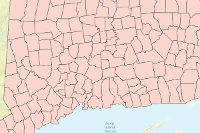

In [27]:
towns = gis.content.get('8b34224054994b03889a9f66f7a4bcd9')
towns

In [28]:
towns_sdf = pandas.DataFrame.spatial.from_layer(towns.layers[0])
len(towns_sdf) #should be 169

169

In [30]:
df_pop[0:4]

Town1    Pop       Tdate  Today      LWdate  LastWeek      TWdate  \
0  Andover   3231  2020-12-23     84  2020-12-16        66  2020-12-09   
1  Ansonia  18721  2020-12-23   1003  2020-12-16       962  2020-12-09   
2  Ashford   4261  2020-12-23     79  2020-12-16        68  2020-12-09   
3     Avon  18302  2020-12-23    496  2020-12-16       462  2020-12-09   

   TwoWeeksAgo  new_7days  new_14days  new_priorweek  7day_avg_rate  \
0           53         18          31             13      79.586152   
1          878         41         125             84      31.286485   
2           60         11          19              8      36.879338   
3          438         34          58             24      26.538864   

   14day_avg_rate  7day_prior_rate  
0       68.532520        57.478888  
1       47.692813        64.099140  
2       31.850337        26.821336  
3       22.636090        18.733316

***
<br>
<br>
$\large{\color{red}{\text{Update online layer using ESRI method}}}$ 
$\large{\color{red}{\text{from https://developers.arcgis.com/python/sample-notebooks/updating-features-in-a-feature-layer/}}}$

In [31]:
#Method 1 overwrite line by line

# from API docs, towns_joined_sdf is the equivalent of cities_df_2 and old_towns is the equivalent of cities_item

old_towns = gis.content.get('fa0a3755cdc848f79018bbd0fa9349c6')
old_towns_layer = old_towns.layers[0]

In [32]:
from arcgis.features import FeatureLayerCollection
cities_flayer_collection = FeatureLayerCollection.fromitem(old_towns)


In [34]:
#Method 1 overwrite line by line

old_towns_fset = old_towns_layer.query() #querying without any conditions returns all the features
old_towns_fset.sdf[0:4]

FID  OBJECTID     GEOID10    Shape__Are    Shape__Len       Town1     Pop  \
0    1         2  0900104720  7.792448e+07  39253.199119      Bethel   19714   
1    2         3  0900108070  8.852534e+07  47272.972979  Bridgeport  144900   
2    3         4  0900108980  9.403365e+07  45692.499570  Brookfield   17002   
3    4         5  0900118500  2.033745e+08  63026.075506     Danbury   84730   

        Tdate  Today      LWdate  ...  new_14days new_priorw  F7day_avg_r  \
0  2020-11-26    637  2020-11-19  ...         170         89    58.696503   
1  2020-11-26   8036  2020-11-19  ...        1684        885    78.773538   
2  2020-11-26    446  2020-11-19  ...         106         47    49.574000   
3  2020-11-26   5358  2020-11-19  ...        1010        542    78.906105   

   F14day_avg_  F7day_prior   Shape__Area  Shape__Length  percent_remote  \
0    61.595096    27.536631  7.792448e+07   39253.199119            23.0   
1    83.012915    68.027211  8.852534e+07   47272.972979            46.0   
2    44.532576    23.526644  9.403365e+07   45692.499570            31.0   
3    85.144408    58.505168  2.033745e+08   63026.075506           100.0   

   percent_schools_case                                              SHAPE  
0             50.000000  {'rings': [[[-8174602.66479217, 5066681.254249...  
1             20.652174  {'rings': [[[-8152302.91314113, 5033456.379785...  
2             50.000000  {'rings': [[[-8173248.68595663, 5078639.431276...  
3             23.255814  {'rings': [[[-8173498.26435158, 5079668.240224...  

[4 rows x 24 columns]

In [35]:
#Method 1 overwrite line by line

overlap_rows = pandas.merge(left = old_towns_fset.sdf, right = df_pop, how='inner',on = 'Town1')
#overlap_rows = overlap_rows.dropna()
len(overlap_rows) #should be 169

169

In [36]:
overlap_rows[0:4]

FID  OBJECTID     GEOID10    Shape__Are    Shape__Len       Town1   Pop_x  \
0    1         2  0900104720  7.792448e+07  39253.199119      Bethel   19714   
1    2         3  0900108070  8.852534e+07  47272.972979  Bridgeport  144900   
2    3         4  0900108980  9.403365e+07  45692.499570  Brookfield   17002   
3    4         5  0900118500  2.033745e+08  63026.075506     Danbury   84730   

      Tdate_x  Today_x    LWdate_x  ...    LWdate_y LastWeek_y    TWdate_y  \
0  2020-11-26      637  2020-11-19  ...  2020-12-16        903  2020-12-09   
1  2020-11-26     8036  2020-11-19  ...  2020-12-16      10603  2020-12-09   
2  2020-11-26      446  2020-11-19  ...  2020-12-16        690  2020-12-09   
3  2020-11-26     5358  2020-11-19  ...  2020-12-16       7319  2020-12-09   

   TwoWeeksAgo  new_7days_y  new_14days_y  new_priorweek  7day_avg_rate  \
0          819           82           166             84      59.421151   
1         9846          444          1201            757      43.774031   
2          608           75           157             82      63.017796   
3         6596          557          1280            723      93.911753   

   14day_avg_rate  7day_prior_rate  
0       60.145799        60.870447  
1       59.203392        74.632752  
2       65.958627        68.899457  
3      107.905785       121.899816  

[4 rows x 37 columns]

In [37]:
#Method 1 overwrite line by line

features_for_update = [] #list containing corrected features
all_features = old_towns_fset.features

# inspect one of the features
all_features[0]

{"geometry": {"rings": [[[-8174602.66479217, 5066681.25424902], [-8174661.10751691, 5066822.46514216], [-8174679.8092529, 5067021.08334184], [-8174701.62787814, 5067191.52151398], [-8174721.22011101, 5067288.97977878], [-8174749.27261489, 5067427.82599839], [-8174698.95618727, 5067572.60795165], [-8174667.23017102, 5067664.43297253], [-8174657.43400453, 5067720.5073434], [-8174628.04570528, 5067889.17774293], [-8174618.36086341, 5067945.4019091], [-8174579.95567004, 5068045.09301512], [-8174557.91439554, 5068102.35646412], [-8174542.6636228, 5068142.1146911], [-8174531.08636243, 5068179.49946396], [-8174496.35468143, 5068291.80314616], [-8174484.8888458, 5068329.33686073], [-8174199.24287437, 5068483.33051187], [-8174092.37614052, 5068557.65775081], [-8174077.12536777, 5068567.44946254], [-8173959.79461979, 5068643.4093817], [-8173954.33991343, 5068647.1184134], [-8173602.23634486, 5068875.89193414], [-8173584.75917974, 5068881.38136445], [-8173532.439009, 5068897.84980757], [-8173515.

In [39]:
#Method 1 overwrite line by line

for town in overlap_rows['Town1']:
    # get the feature to be updated
    original_feature = [f for f in all_features if f.attributes['Town1'] == town][0]
    feature_to_be_updated = deepcopy(original_feature)
    
    print(str(original_feature))
    
    # get the matching row from csv
    matching_row = df_pop.where(df_pop.Town1 == town).dropna()
    
    # assign the updated values
    feature_to_be_updated.attributes['Tdate'] = str(matching_row['Tdate'].iloc[0])
    feature_to_be_updated.attributes['Today'] = int(matching_row['Today'].iloc[0])
    feature_to_be_updated.attributes['LWdate'] = str(matching_row['LWdate'].iloc[0])
    feature_to_be_updated.attributes['LastWeek'] = int(matching_row['LastWeek'].iloc[0])  
    feature_to_be_updated.attributes['TWdate'] = str(matching_row['TWdate'].iloc[0])
    feature_to_be_updated.attributes['TwoWeeksAg'] = int(matching_row['TwoWeeksAgo'].iloc[0])                                                  
    feature_to_be_updated.attributes['new_7days'] = int(matching_row['new_7days'].iloc[0])
    feature_to_be_updated.attributes['new_14days'] = int(matching_row['new_14days'].iloc[0])
    feature_to_be_updated.attributes['new_priorw'] = int(matching_row['new_priorweek'].iloc[0])  
    feature_to_be_updated.attributes['F7day_avg_r'] = float(matching_row['7day_avg_rate'].iloc[0])
    feature_to_be_updated.attributes['F14day_avg_'] = float(matching_row['14day_avg_rate'].iloc[0])
    #feature_to_be_updated.attributes['percent_remote'] = float(matching_row['percent_remote'].iloc[0])                                                          
    #feature_to_be_updated.attributes['percent_schools_case'] = float(matching_row['percent_schools_case'].iloc[0])
    
    #add this to the list of features to be updated
    features_for_update.append(feature_to_be_updated)
    
    print(str(feature_to_be_updated))
    print("========================================================================")

{"geometry": {"rings": [[[-8174602.66479217, 5066681.25424902], [-8174661.10751691, 5066822.46514216], [-8174679.8092529, 5067021.08334184], [-8174701.62787814, 5067191.52151398], [-8174721.22011101, 5067288.97977878], [-8174749.27261489, 5067427.82599839], [-8174698.95618727, 5067572.60795165], [-8174667.23017102, 5067664.43297253], [-8174657.43400453, 5067720.5073434], [-8174628.04570528, 5067889.17774293], [-8174618.36086341, 5067945.4019091], [-8174579.95567004, 5068045.09301512], [-8174557.91439554, 5068102.35646412], [-8174542.6636228, 5068142.1146911], [-8174531.08636243, 5068179.49946396], [-8174496.35468143, 5068291.80314616], [-8174484.8888458, 5068329.33686073], [-8174199.24287437, 5068483.33051187], [-8174092.37614052, 5068557.65775081], [-8174077.12536777, 5068567.44946254], [-8173959.79461979, 5068643.4093817], [-8173954.33991343, 5068647.1184134], [-8173602.23634486, 5068875.89193414], [-8173584.75917974, 5068881.38136445], [-8173532.439009, 5068897.84980757], [-8173515.

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



{"geometry": {"rings": [[[-8087934.73774976, 5113629.23844431], [-8088089.58329434, 5113564.54868801], [-8088108.06228097, 5113557.24510244], [-8088173.18418283, 5113531.7567919], [-8088191.7745942, 5113523.11168773], [-8088211.58947632, 5113514.16847086], [-8088236.74764007, 5113506.11962301], [-8088248.32490044, 5113501.20090833], [-8088258.23229144, 5113497.17642199], [-8088267.36051019, 5113494.19535682], [-8088287.50936618, 5113478.3958208], [-8088348.06715868, 5113430.84804182], [-8088368.32733929, 5113415.1975348], [-8088368.43866391, 5113430.40086497], [-8088368.77263779, 5113476.01086603], [-8088368.88396242, 5113480.03534349], [-8088368.88396242, 5113491.36335249], [-8088397.82706328, 5113471.24122637], [-8088484.76759039, 5113411.02415993], [-8088513.82201587, 5113391.05112665], [-8088684.58608073, 5113356.62032183], [-8088846.22202695, 5113304.00547592], [-8088890.6385498, 5113279.26325533], [-8089023.88801828, 5113205.33481933], [-8089068.41586577, 5113180.7417743], [-8089

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [40]:
len(features_for_update) #hope for 169

169

In [ ]:
#pushes the update to AGOL
lt1 = old_towns_layer.edit_features(updates=features_for_update)
lt1
